In [1]:
# initialise and load WB annotations
%run ~/relmapping/annot/notebooks/__init__.ipynb
fp_ = 'WS260_ce10/WS260_ce10.transcripts.annot.gtf.gz'
df_annot = yp.df_gfftags_unpack(yp.read_wbgtf(fp_, parse_attr=False), name='attribute')

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


In [2]:
fp_ = 'annot/Fig2D2_genomic_regions/Fig2D2_genomic_regions.tsv'
df_regions = pd.read_csv(fp_, sep='\t')

In [3]:
df_regions.head()

,chrom,start,end,type,strand,gene_id
0,chrI,0,3646,intergenic,.,.
1,chrI,3646,3847,gene_end,-,WBGene00023193
2,chrI,3847,3909,exonic,-,WBGene00023193
3,chrI,3909,4015,intergenic,.,.
4,chrI,4015,4216,gene_end,-,WBGene00022277


In [4]:
d_ = collections.OrderedDict([
    ('outronic', yp.RED),
    ('exonic', yp.ORANGE),
    ('gene_end', yp.PURPLE),
    ('intronic', yp.YELLOW),
    ('intergenic', yp.SKYBLUE),
    ('mixed', '0.5'),
])

df_regions['length'] = df_regions['end'] - df_regions['start']
df_length = df_regions.groupby('type').agg({'length': np.sum}).loc[d_.keys()]
df_length

,length
type,
outronic,9056870
exonic,26929718
gene_end,3760322
intronic,32394016
intergenic,24947484
mixed,3197660


In [5]:
#df_plt = pd.DataFrame({'length': df_length['length'].tolist()},
#    index = ["%s\n(%sbp)" % (type_, yp.f_uk(length_)) for type_, length_ in zip(df_length.index, df_length.length)],
#)
#df_plt

df_plt = pd.DataFrame({'length': df_length['length'].tolist()},
    index = ["%s (%.1f%%)" % (type_, 100.0*length_ / df_length['length'].sum()) for type_, length_ in zip(df_length.index, df_length.length)],
)
df_plt

,length
outronic (9.0%),9056870
exonic (26.9%),26929718
gene_end (3.7%),3760322
intronic (32.3%),32394016
intergenic (24.9%),24947484
mixed (3.2%),3197660


In [6]:
df_regl = regl_Apr27()
df_mode = pd.DataFrame()
df_mode['chrom'] = df_regl['chrom'].copy()
df_mode['start'] = summit_pos(df_regl)
df_mode['end'] = summit_pos(df_regl) + 1
df_mode['type'] = BedTool.from_dataframe(df_mode).map(
    b=BedTool.from_dataframe(df_regions[['chrom', 'start', 'end', 'type']]).fn,
    c=4, o='distinct',
).to_dataframe()['name']

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"


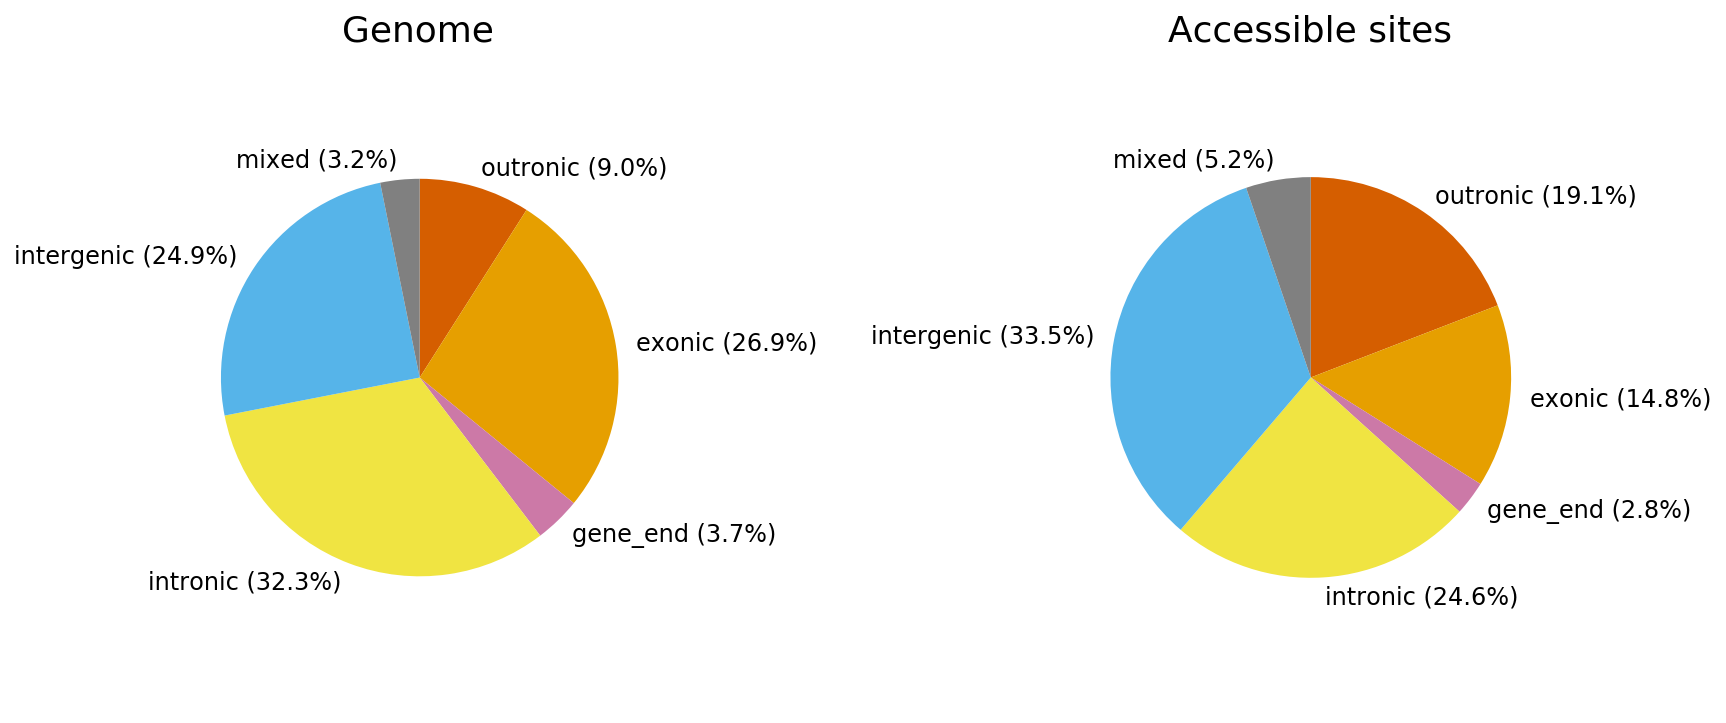

In [7]:
plt.figure(figsize=(12,6)).subplots_adjust(wspace=1)
plt.subplot(1,2,1)
df_plt['length'].plot( 
    label='',
    kind='pie',
    colors=d_.values(),
    counterclock=False,
    #autopct='%.1f%%',
    startangle=90, # avoid 'mixed' label overlapping with the title
    fontsize=12,
);
#plt.title('Genome (%sbp)' % (yp.f_uk(df_plt['length'].sum()),), fontsize=18)
plt.title('Genome', fontsize=18)# (%sbp)' % (yp.f_uk(df_plt['length'].sum()),), fontsize=18)
plt.axis('equal');

df_mode_agg = df_mode['type'].value_counts().loc[d_.keys()]
#df_mode_agg.index = ["%s\n(%s sites)" % (type_, yp.f_uk(count_)) for type_, count_ in zip(df_mode_agg.index, df_mode_agg.values)]
df_mode_agg.index = ["%s (%.1f%%)" % (type_, 100.0*frac_) for type_, frac_ in zip(df_mode_agg.index, df_mode_agg.values / df_mode_agg.values.sum())]

plt.subplot(1,2,2)
df_mode_agg.plot( 
    label='',
    kind='pie',
    colors=d_.values(),
    counterclock=False,
    #autopct='%.1f%%',
    startangle=90, # avoid 'mixed' label overlapping with the title
    fontsize=12,
);
#plt.title('All accessible sites (%s)' % (yp.f_uk(sum(df_mode_agg.values)),), fontsize=18)
plt.title('Accessible sites', fontsize=18)# (%s)' % (yp.f_uk(sum(df_mode_agg.values)),), fontsize=18)
plt.axis('equal');

plt.savefig('annot_Apr27/Fig2S2A_genomic_regions.pdf', bbox_inches='tight', transparent=True)

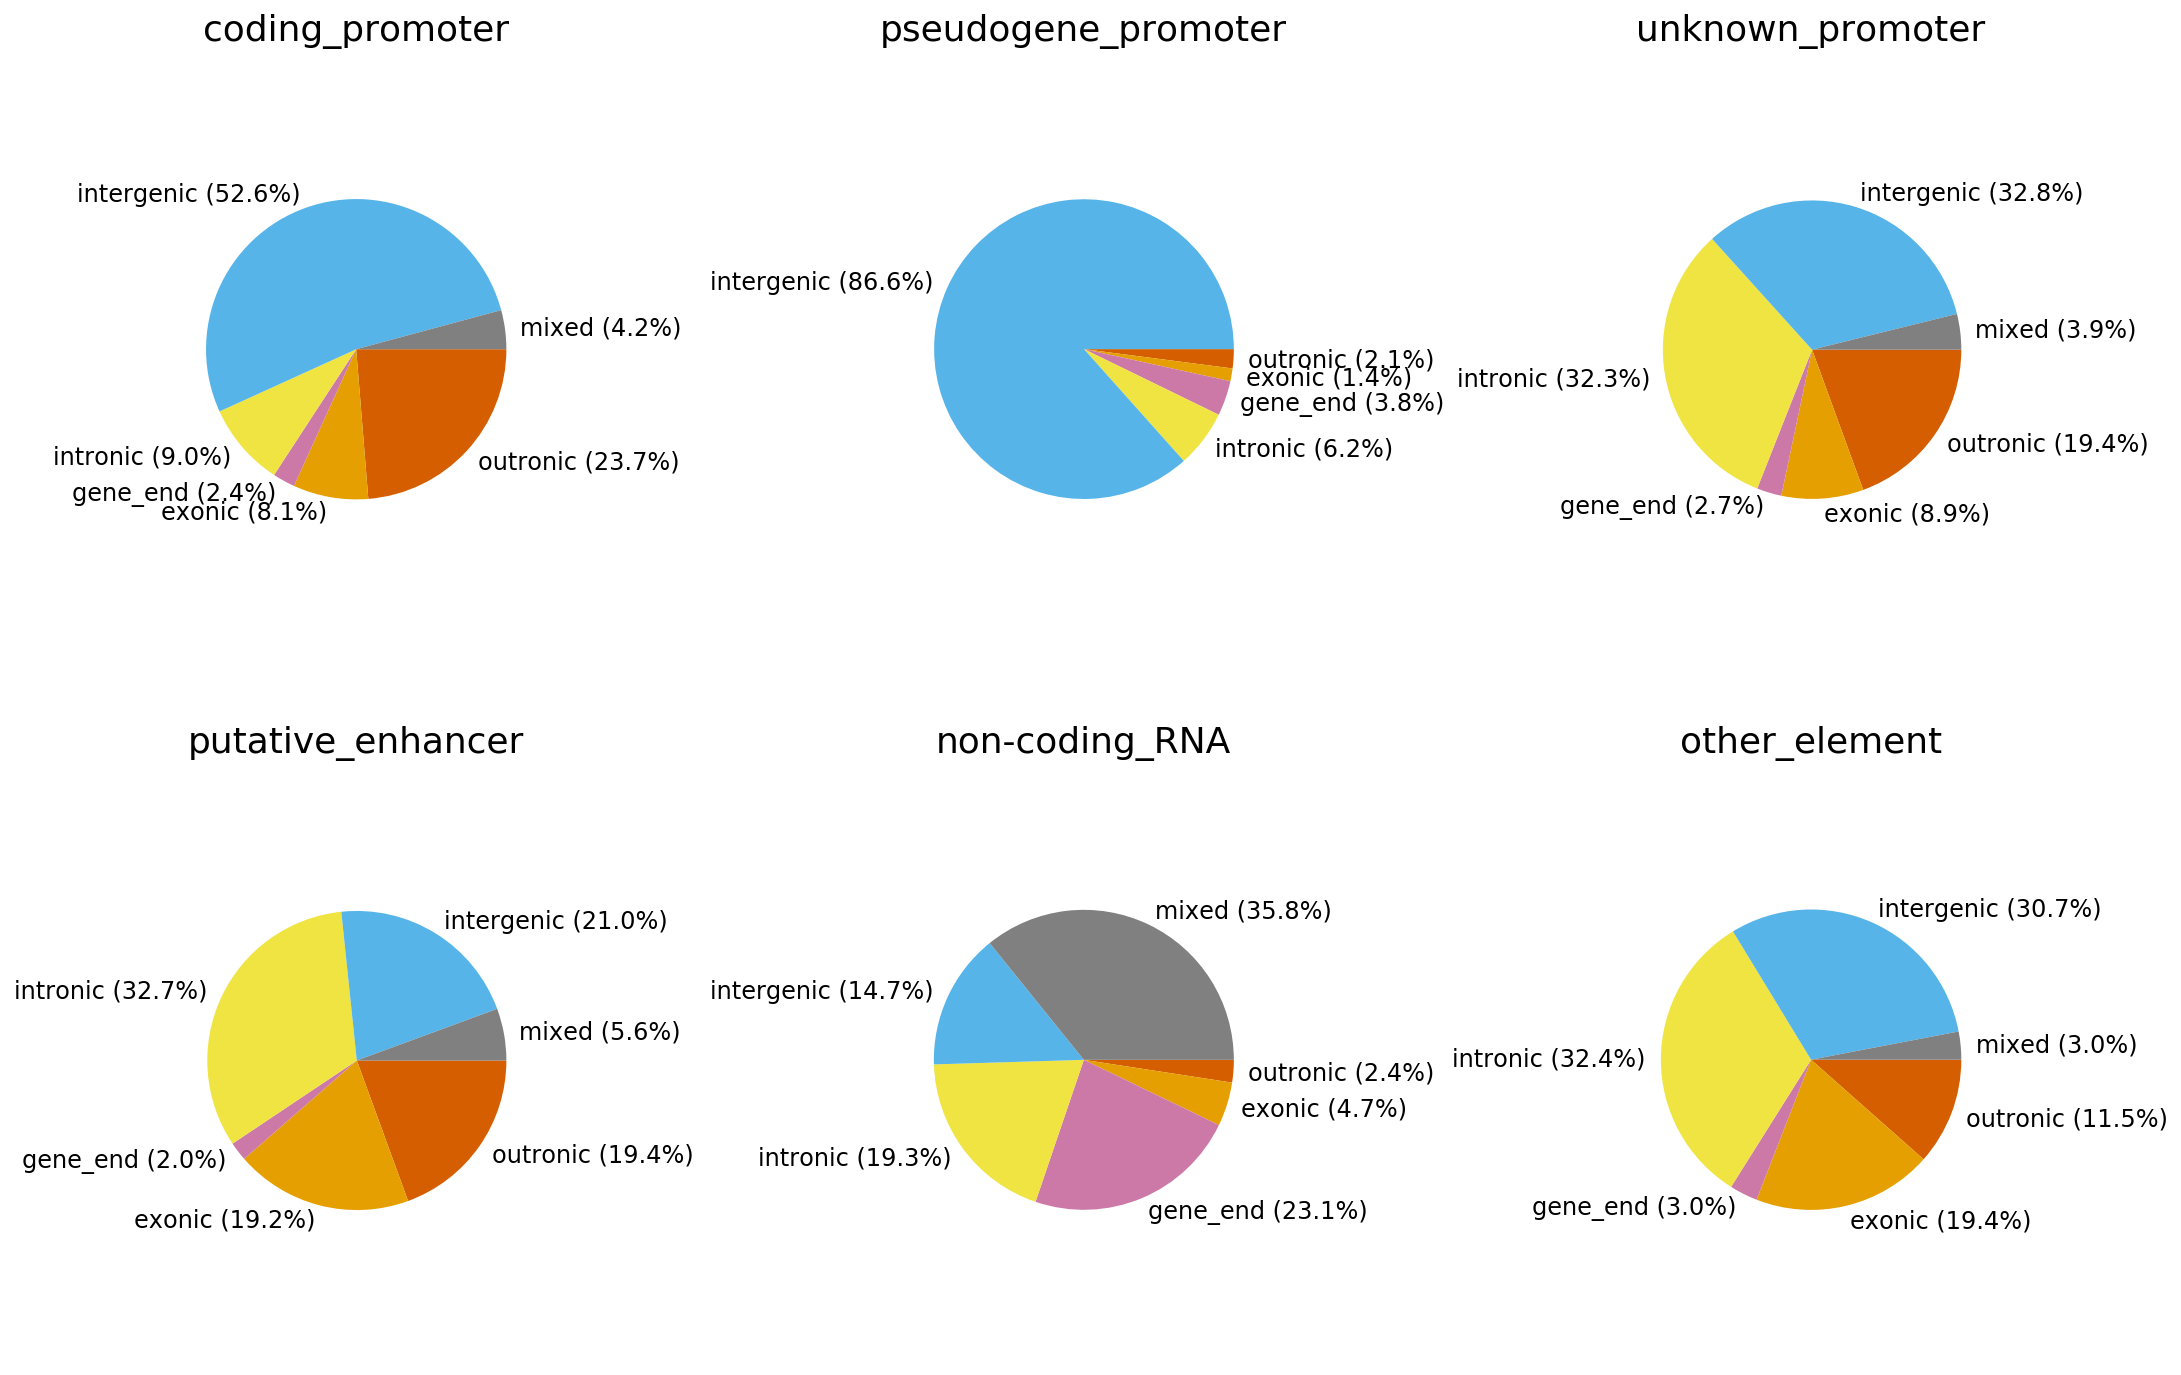

In [8]:
def plot_(m_, label_):
    df_mode_agg = df_mode.loc[m_]['type'].value_counts().loc[d_.keys()].fillna(0)
    #df_mode_agg.index = ["%s\n(%s sites)" % (type_, yp.f_uk(count_)) for type_, count_ in zip(df_mode_agg.index, df_mode_agg.values)]
    df_mode_agg.index = ["%s (%.1f%%)" % (type_, 100.0*frac_) for type_, frac_ in zip(df_mode_agg.index, df_mode_agg.values / df_mode_agg.values.sum())]

    #plt.subplot(1,2,2)
    df_mode_agg.plot( 
        #title='sites annotated as\n%s (%s)' % (label_, yp.f_uk(sum(df_mode_agg.values)),),
        label='',
        kind='pie',
        colors=d_.values(),
        counterclock=False,
        #autopct='%.1f%%',
        startangle=0, # avoid 'mixed' label overlapping with the title
        fontsize=12,
    );
    #plt.title('%s\n(%s sites)' % (label_, yp.f_uk(sum(df_mode_agg.values)),), fontsize=18)
    plt.title('%s' % (label_,), fontsize=18)
    plt.axis('equal');

plt.figure(figsize=(16,12)).subplots_adjust(wspace=1.2)
plt.subplot(2,3,1)
plot_(df_regl['annot'] == 'coding_promoter', 'coding_promoter')
plt.subplot(2,3,2)
plot_(df_regl['annot'] == 'pseudogene_promoter', 'pseudogene_promoter')
plt.subplot(2,3,3)
plot_(df_regl['annot'] == 'unknown_promoter', 'unknown_promoter')
plt.subplot(2,3,4)
plot_(df_regl['annot'] == 'putative_enhancer', 'putative_enhancer')
plt.subplot(2,3,5)
plot_(df_regl['annot'] == 'non-coding_RNA', 'non-coding_RNA')
plt.subplot(2,3,6)
plot_(df_regl['annot'] == 'other_element', 'other_element')

plt.savefig('annot_Apr27/Fig2S2B_genomic_regions_by_annot.pdf', bbox_inches='tight', transparent=True)